The story starts with one of the surviving dialogues of Democritus concerning the intellect and the senses : 

Intellect claims :
“By convention there is sweetness, by convention bitterness, by convention color, in reality only atoms and the void.” 
and the senses respond : 
“Foolish intellect! Do you seek to overthrow us, while it is from us that you take your evidence?” 

This single line from 2000+ years ago would be the very first foundations of Reductionism, Quantum Mechanics, and maybe
Quantum Computing. Well don't take my word for it. Here is a great book for you to follow from the originator of what we now 
call Schrodinger Equation, forming the basis for the work that resulted Nobel Prize in Physics in 1933.

* _E. Schrodinger, What is Life? With Mind and Matter and Autobiographical Sketches, Cambridge University Press (reprinted edition), 2012._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 
%matplotlib inline

In [2]:
# Let's start by writing time dependent Schrodinger Equation 

Let's start with the full equation:
$$
\newcommand{\op}[1]{\mathbf{#1}}
$$
$$
i\hbar\frac{\partial \Psi}{\partial t} = \op H \Psi 
$$
If you didn't know that $\op{H}$ represented an operator, but instead treated it as a number, then the solution would be relatively easily found by integration. It turns out you can do this with an operator just the same, so the solution is then:
$$
\Psi(x,t+\Delta t) = e^{-i\op{H}\Delta t/\hbar} \Psi(x,t)
$$
Or the __"time evolution operator"__ is given by:
$$
\op{U(\Delta t)} = e^{-i\op{H}\Delta t/\hbar}
$$
The exponent of an operator can be treated uses an infinite series, so:
$$
e^{-i\op{H}\Delta t/\hbar} = \sum_n \frac{ (-i\op{H}\Delta t/\hbar)^n}{n!}
$$
If you try to evaluate this numerically, you will find that it very quickly diverges from the correct answer, for any appreciable size for $\Delta t$, so for *numerical* evaluation you must have, $\Delta t < 2/\lambda_{max}$, where $\lambda_{max}$ is the largest Energy level of the Hamiltonian. The reason is subtle and rather complicated, and can be found in [Numerical Recipes 3d edition 17.5 in the library](https://eds.a.ebscohost.com/eds/detail/detail?vid=1&sid=8847ad4b-021b-4fed-9228-f0c67a34c6b6%40sessionmgr4010&bdata=JnNpdGU9ZWRzLWxpdmU%3d#AN=unh.b2802390&db=cat00099a) [or 2nd edition online, page 735](https://www2.units.it/ipl/students_area/imm2/files/Numerical_Recipes.pdf). If you take a $\Delta t$ that is larger, then he errors in the calculation pile up so quickly that this approach is not practical if we try to evaluate it directly this way. We also note that this is *not* a fast way to evaluate a time step, since the matrix multiplication is of order $N^2$ in operations.

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.fftpack as fft
# Input parameters.
hbar=1
m=1
N = 2**12   # FFT is a lot faster on domains which are powers of 2.
a = 400.0
step_low = 0.
step_high= 1.
V0 = 10.
# Define the space:
n = np.arange(N)
x0 = -a/2.
xN = a/2.
Delta_x = (xN - x0)/N
print ("Delta_x =",Delta_x) 
x = x0 + n*Delta_x  # This creates the correct array of x values.
###################################################
# Potential Definition.
###################################################
V=np.zeros(N)
for i in range(N):
    if x[i]>= step_low and x[i]<= step_high:
        V[i]= V0
###################################################
# Setup the Hamiltonian for function V
#
Mdd = 1./(Delta_x**2)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) +\
                       np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
En,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the 
#wavefunction vectors can accessed as psi[n]

Delta_x = 0.09765625


In [4]:
# Set the timestep
dt_max = 2/np.max(En) # Stability Criteria
dt= 0.001
if dt>dt_max:
    print ("WARNING: dt is in the instable region!!!!!")

In [5]:
# Define the initial wave function to propogate : 
g_x0=-10.
g_k0=6.
g_sig=2.

# Gaussian in k-space, where p = \hbar k, with 
#a momentum k0, and x-space psi(x,0) (2a/pi)^1/4 e^{-ax^2}
def psi0(x,g_x0,g_k0,g_sig):
    _Norm_x=np.sqrt(Delta_x/g_sig)/(np.pi**0.25)
    return(_Norm_x*np.exp(-(x-g_x0)**2/(2.*g_sig*g_sig)+1j*g_k0*x))

psi_t0 = psi0(x,g_x0,g_k0,g_sig)

In [6]:
H

array([[104.8576, -52.4288,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [-52.4288, 104.8576, -52.4288, ...,   0.    ,   0.    ,   0.    ],
       [  0.    , -52.4288, 104.8576, ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  0.    ,   0.    ,   0.    , ..., 104.8576, -52.4288,   0.    ],
       [  0.    ,   0.    ,   0.    , ..., -52.4288, 104.8576, -52.4288],
       [  0.    ,   0.    ,   0.    , ...,   0.    , -52.4288, 104.8576]])

If we try to evaluate the equation 
$$
e^{-i\op{H}\Delta t/\hbar} = \sum_n \frac{ (-i\op{H}\Delta t/\hbar)^n}{n!}
$$
directly. Taking into account the condition for the stability of the differential equation 

In [7]:
print ("Check if H is actually Hermetian! ",np.array_equal(H.conj().T,H)) # Is H Hermetian?

Check if H is actually Hermetian!  True


In [8]:
Ut_mat = np.diag(np.ones(N,dtype="complex128"),0)
print ("Creating a U(dt={}) Matrix".format(dt))
for n in range(1,3):  # Do the summation. Since this is matrices, this takes a little while if N is large.
    Ut_mat += np.linalg.matrix_power((-1j*dt*H/hbar),n)/math.factorial(n)

Creating a U(dt=0.001) Matrix


In [9]:
p=Ut_mat.dot(psi_t0)
print ("How much is the normalization changing per step? From {} to {}".format(np.linalg.norm(psi_t0),np.linalg.norm(p)))
print ("Number of steps at which point norm is off by a factor of 2: ",1/(np.linalg.norm(p)-1))

How much is the normalization changing per step? From 1.0 to 1.0000000127814088
Number of steps at which point norm is off by a factor of 2:  78238636.60618041


In [10]:
Ut_mat_dagger = Ut_mat.conj().T
print ("If the U(t) matrix properly unitary? ",np.array_equal(Ut_mat_dagger,Ut_mat))
print ("Didn't think so, or else the norm would not change!")
print ("This should be the Identity matrix, but the diagonal terms are not 1!!")
print (np.diag(Ut_mat.dot(Ut_mat_dagger))[0:5])

If the U(t) matrix properly unitary?  False
Didn't think so, or else the norm would not change!
This should be the Identity matrix, but the diagonal terms are not 1!!
[1.00007934+0.j 1.00013034+0.j 1.00013223+0.j 1.00013223+0.j
 1.00013223+0.j]


We can now try to evaluate the movement of the gaussian by repeatedly applying $U(\Delta t)$. Since $\Delta t$ is small, it takes a fair number of steps. The speed is SLOW, because each step evaluates at an order $N^2$ speed, where the FFT algorithms performs at $N\log N$.

In [11]:
psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0
psi_tu = []
for t in range(3500):
    psi_t1 = Ut_mat.dot(psi_t1)
    if t>0 and t%500==0:
        psi_tu.append( (t,psi_t1))
psi_tu.append( (t,psi_t1))

In [12]:
psi_tu

[(500, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (1000, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (1500, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (2000, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (2500, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (3000, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])),
 (3499, array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]))]

We need to test that our results make sense. We check the normalization for each step, the expectation value of the energy $<E>$, and the expectation value of the position $<x>$. The position is expected to increase by $p$ times $t$, until it hits the barrier where the wave splits up.

In [13]:
print ("Normalization: ",np.linalg.norm(psi_tu[-1][1]))
vev_E0=float(np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))))
vev_x0=float(np.real(np.sum(np.conjugate(psi_t0)*x*psi_t0)))
print ("<E_(t=0)> = {:8.4f}  <x_(t=0)>= {:8.4f}".format(vev_E0,vev_x0))

for t,p in psi_tu:
    norm = np.linalg.norm(p)
    vev_E1=float(np.real(np.sum(np.conjugate(p)*H.dot(p))))
    vev_x1=float(np.real(np.sum(np.conjugate(p)*x*p)))
    print ("dt={:7.1f}  norm = {:8.5f}  <E> = {:8.4f}  <x_(dt)>= {:8.4g}"\
           .format(t,norm,vev_E1,vev_x1))

Normalization:  1.0000447363612583
<E_(t=0)> =  17.5429  <x_(t=0)>= -10.0000
dt=  500.0  norm =  1.00001  <E> =  17.5432  <x_(dt)>=   -7.164
dt= 1000.0  norm =  1.00001  <E> =  17.5434  <x_(dt)>=   -4.335
dt= 1500.0  norm =  1.00002  <E> =  17.5436  <x_(dt)>=    -1.55
dt= 2000.0  norm =  1.00003  <E> =  17.5439  <x_(dt)>=   0.8044
dt= 2500.0  norm =  1.00003  <E> =  17.5441  <x_(dt)>=     2.91
dt= 3000.0  norm =  1.00004  <E> =  17.5443  <x_(dt)>=    5.103
dt= 3499.0  norm =  1.00004  <E> =  17.5446  <x_(dt)>=    7.305


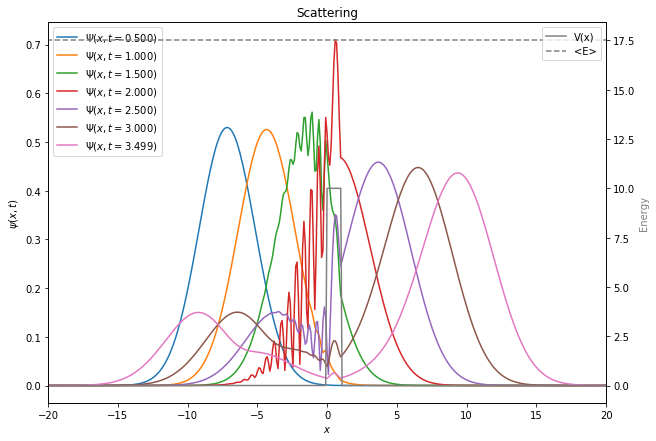

In [29]:
fig,ax1 = plt.subplots(figsize=[10,7])
if vev_E0>max(V):
    plt.title('Scattering')
else:
    plt.title('Tunneling')
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
#ax1.plot(x,np.abs(psi_t0)/np.sqrt(Delta_x),label="$\Psi(x,t=0)$")
for t,p in psi_tu:
    ax1.plot(x,np.abs(p)/np.sqrt(Delta_x),label="$\Psi(x,t={:6.3f})$".format(t*dt))
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.plot(x,V,color="grey",label="V(x)")
ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
ax2.set_ylabel("Energy",color="grey")
ax2.set_xlim(g_x0-5*g_sig,-g_x0+5*g_sig)
ax2.legend(loc='upper right')
#plt.savefig("Displaced_state.pdf")
plt.show()

So for any isolated region of the universe that you want to consider, quantum mechanics describes the evolution in time of the state of that region, which we represent as a linear combination – a superposition – of all the possible configurations of elementary particles in that region. So, this is a bizarre picture of reality, where a given particle is not here, not there, but in a sort of weighted sum over all the places it could be.

The part where it maybe doesn’t do so well is the “from us you take your evidence” part. What’s the problem? Well, if you take quantum mechanics seriously, you yourself ought to be in a superposition of different places at once. After all, we’re all made of elementary particles too, right?

Basically, physical laws are supposed to be universal. They’re supposed to describe human beings the same way they describe super- novas and quasars: all just examples of vast, complicated clumps of particles interacting according to simple rules.

But wait: if we’re not here making nosy measurements, wreck- ing the pristine beauty of quantum mechanics, then how did “we” (whatever that means) ever get the evidence in the first place that quantum mechanics is true? How did we ever come to believe in this theory that seems so uncomfortable with the fact of our own existence?

So, that’s the modern version of the Democritus dilemma, and physicists and philosophers have been arguing about it for almost a hundred years

Regarding interpretations of QM, It's better to agree with every interpretation to the extent it says there’s a problem, and disagree with every interpretation to the extent where it claims to have solved the problem

But what if you want to apply quantum mechanics to the whole universe, including yourself? The answer, in the epistemic-type interpretations, is simply that you don’t ask that sort of question! Incidentally, that was Bohr’s all-time favorite philosophical move, his WWF piledriver: “You’re not allowed to ask such a question!”

If human beings were regularly put into superposition, then the whole business of drawing a line between “classical observers” and the rest of the universe would become untenable.

But alright – human brains are wet, goopy, sloppy things, and maybe we won’t be able to maintain them in coherent superposition for 500 million years. So what’s the next best thing? Well, we could try to put a computer in superposition. The more sophisticated the computer was – the more it resembled something like a brain, like ourselves – the further up we would have pushed the “line” between quantum and classical. You can see how it’s only a minuscule step from here to the idea of quantum computing.

Philosophy is an intellectual clean-up job - the janitors who come in after the scientists have made a mess, to try and pick up the pieces. It's fine to tell people to “Shut up and calculate,” but the question is, what should they calculate? At least in quantum computing, the sorts of things that we like to calculate – capacities of quantum channels, error probabilities of quantum algorithms – are things people would never have thought to calculate.